In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, date

# Load data

Use 1 month of data from the Hainich site and using a subset of variables

Note for simplicity gap filled values are not excluded

In [3]:
hai_path = Path("FLX_DE-Hai_FLUXNET2015_FULLSET_HH_2000-2012_1-4.csv")
hai_raw = pd.read_csv("../MeteoECGapFilling/data" / hai_path, na_values=["-9999", "-9999.99"], parse_dates=[0, 1])

In [4]:
meteo_vars = {
    "TA_F": "TA",
    "SW_IN_F": "SW_IN",
    "LW_IN_F": "LW_IN",
    "VPD_F": "VPD",
    "PA_F": "PA"
}

hai = (hai_raw[
           hai_raw.TIMESTAMP_START.between(
               datetime(2000, 1, 1),
               datetime(2000, 1, 31)
           )]
       .rename(columns=meteo_vars)
       .set_index("TIMESTAMP_END")
       .loc[:, meteo_vars.values()])

In [5]:
hai

,TA,SW_IN,LW_IN,VPD,PA,PA
TIMESTAMP_END,,,,,,
2000-01-01 00:30:00,-0.60,0.00,302.475,0.222,96.63,96.63
2000-01-01 01:00:00,-0.65,0.00,302.475,0.122,96.58,96.58
2000-01-01 01:30:00,-0.58,0.00,301.677,0.090,96.56,96.56
2000-01-01 02:00:00,-0.51,0.00,301.677,0.110,96.56,96.56
2000-01-01 02:30:00,-0.49,0.00,301.677,0.102,96.57,96.57
...,...,...,...,...,...,...
2000-01-30 22:30:00,6.87,0.19,346.510,0.189,95.50,95.50
2000-01-30 23:00:00,7.45,0.06,346.510,0.620,95.47,95.47
2000-01-30 23:30:00,7.66,0.00,346.510,0.842,95.45,95.45


# Gaussian Process

In [6]:
import torch
import gpytorch
from matplotlib import pyplot as plt

## Functions

In [7]:
# add a column "time" which is going to be the x variable, while TA is the y
train_x = torch.linspace(0, 1, len(hai)).cuda()
train_y = torch.tensor(hai.TA, dtype=torch.float).cuda()
#train_y = torch.sin(train_x * (2 * torch.pi)) + torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.04))

In [30]:
def train(model, likelihood, training_iter=50):
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        model.printer(i, loss)


def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

@torch.no_grad()
def plot_prediction(pred_dist, test_x = torch.linspace(0, 1, 51)):
    f, ax = plt.subplots(1, 1, figsize=(12, 10))
    # Get upper and lower confidence bounds
    lower, upper = pred_dist.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), pred_dist.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([11, -11]) #TODO hardcoded
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [31]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def printer(self, i, loss):
        print('Iter %d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1,  loss.item(),
        self.covar_module.base_kernel.lengthscale.item(),
        self.likelihood.noise.item()
    ))

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = ExactGPModel(train_x, train_y, likelihood).cuda()


In [32]:
test_x = torch.linspace(0, 1, len(hai) * 2).cuda()

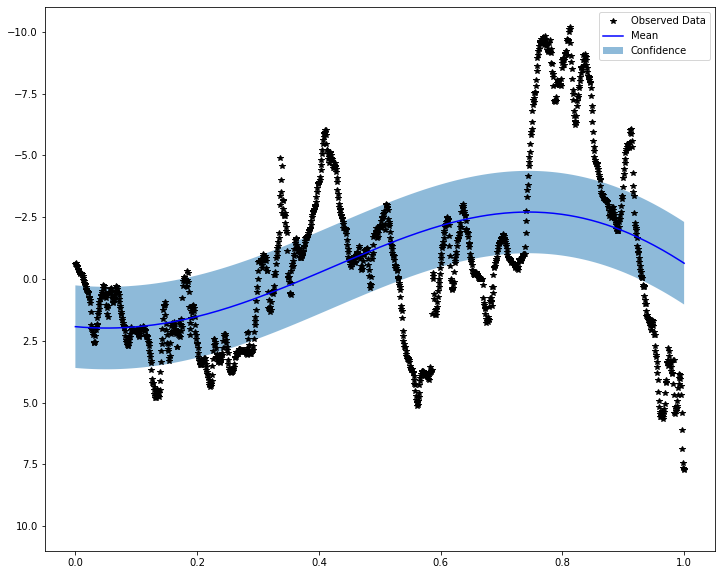

In [33]:
pred = predict(model, likelihood, test_x)
plot_prediction(pred, test_x)

In [34]:
train(model, likelihood)

Iter 1 - Loss: 8.033   lengthscale: 0.644   noise: 0.744
Iter 2 - Loss: 7.466   lengthscale: 0.598   noise: 0.798
Iter 3 - Loss: 6.960   lengthscale: 0.555   noise: 0.853
Iter 4 - Loss: 6.513   lengthscale: 0.514   noise: 0.911
Iter 5 - Loss: 6.113   lengthscale: 0.476   noise: 0.969
Iter 6 - Loss: 5.753   lengthscale: 0.440   noise: 1.029
Iter 7 - Loss: 5.413   lengthscale: 0.406   noise: 1.090
Iter 8 - Loss: 5.089   lengthscale: 0.374   noise: 1.151
Iter 9 - Loss: 4.747   lengthscale: 0.344   noise: 1.212
Iter 10 - Loss: 4.374   lengthscale: 0.315   noise: 1.272
Iter 11 - Loss: 3.959   lengthscale: 0.289   noise: 1.331
Iter 12 - Loss: 3.526   lengthscale: 0.264   noise: 1.388
Iter 13 - Loss: 3.111   lengthscale: 0.241   noise: 1.442
Iter 14 - Loss: 2.767   lengthscale: 0.219   noise: 1.493
Iter 15 - Loss: 2.502   lengthscale: 0.200   noise: 1.541
Iter 16 - Loss: 2.322   lengthscale: 0.182   noise: 1.586
Iter 17 - Loss: 2.209   lengthscale: 0.167   noise: 1.628
Iter 18 - Loss: 2.144  

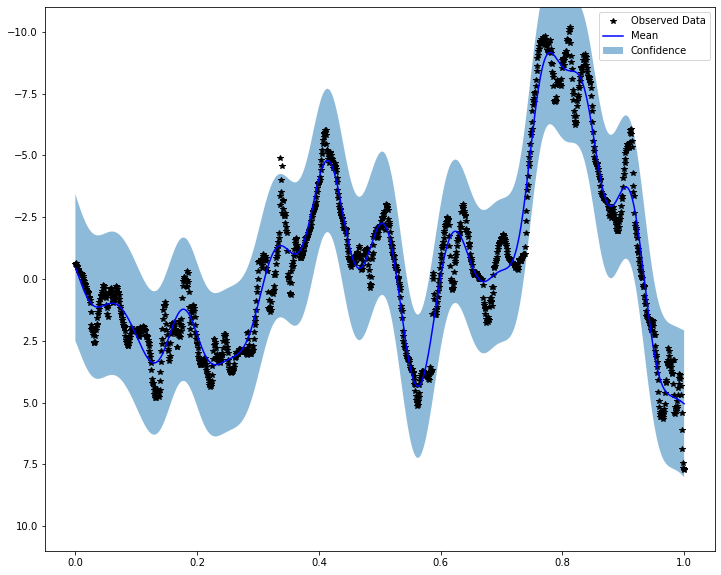

In [35]:
pred = predict(model, likelihood, test_x)
plot_prediction(pred, test_x)

## Try with 2 different kernels

In [16]:
# We will use the simplest form of GP model, exact inference
class GP2Kernel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP2Kernel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.AdditiveKernel(gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood2k = gpytorch.likelihoods.GaussianLikelihood().cuda()
model2k = GP2Kernel(train_x, train_y, likelihood).cuda()


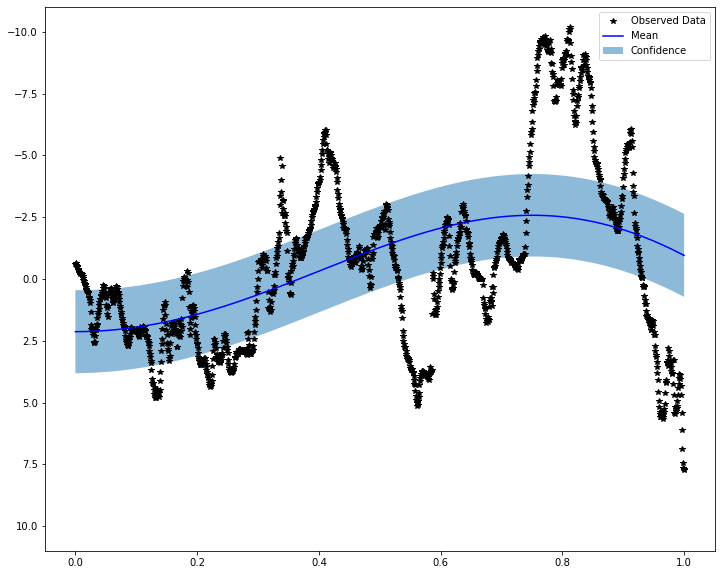

In [17]:
pred2k = predict(model2k, likelihood2k, test_x)
plot_prediction(pred2k, test_x)

In [18]:
# Find optimal model hyperparameters
model2k.train()
likelihood2k.train()
training_iter = 50

# Use the adam optimizer
optimizer = torch.optim.Adam(model2k.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2k, model2k)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model2k(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f ' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 7.830 
Iter 2/50 - Loss: 7.701 
Iter 3/50 - Loss: 7.584 
Iter 4/50 - Loss: 7.468 
Iter 5/50 - Loss: 7.334 
Iter 6/50 - Loss: 7.164 
Iter 7/50 - Loss: 6.927 
Iter 8/50 - Loss: 6.588 
Iter 9/50 - Loss: 6.110 
Iter 10/50 - Loss: 5.504 
Iter 11/50 - Loss: 4.858 
Iter 12/50 - Loss: 4.275 
Iter 13/50 - Loss: 3.790 
Iter 14/50 - Loss: 3.411 
Iter 15/50 - Loss: 3.147 
Iter 16/50 - Loss: 2.990 
Iter 17/50 - Loss: 2.911 
Iter 18/50 - Loss: 2.864 
Iter 19/50 - Loss: 2.820 
Iter 20/50 - Loss: 2.782 
Iter 21/50 - Loss: 2.730 
Iter 22/50 - Loss: 2.679 
Iter 23/50 - Loss: 2.633 
Iter 24/50 - Loss: 2.597 
Iter 25/50 - Loss: 2.544 
Iter 26/50 - Loss: 2.488 
Iter 27/50 - Loss: 2.419 
Iter 28/50 - Loss: 2.339 
Iter 29/50 - Loss: 2.239 
Iter 30/50 - Loss: 2.155 
Iter 31/50 - Loss: 2.076 
Iter 32/50 - Loss: 1.990 
Iter 33/50 - Loss: 1.934 
Iter 34/50 - Loss: 1.842 
Iter 35/50 - Loss: 1.758 
Iter 36/50 - Loss: 1.703 
Iter 37/50 - Loss: 1.626 
Iter 38/50 - Loss: 1.559 
Iter 39/50 - Loss: 1.

In [ ]:
model2k.eval()
plot_func_dist(likelihood(model2k(test_x)))

In [ ]:
model2k.covar_module.kernels[0].base_kernel.lengthscale.item()

In [ ]:
model2k.covar_module.kernels[1].base_kernel.lengthscale.item()

# Gaussian Processess Factor Analysis

In [ ]:
# so what we need to do?
# take inspiration from https://docs.gpytorch.ai/en/stable/examples/045_GPLVM/Gaussian_Process_Latent_Variable_Models_with_Stochastic_Variational_Inference.html